In [1]:
import os
import numpy as np
from highway_env.ngsim_utils.trajectory_gen import (
    process_raw_trajectory,
    first_valid_index,
    process_raw_trajectory
)

episode_root = "highway_env/data/processed_10s"

scene =  "us-101"
prebuilt_dir = os.path.join(episode_root, scene, "prebuilt")

traj_path = os.path.join(prebuilt_dir, f"trajectory_train.npy")

traj_all_by_episode  = np.load(traj_path, allow_pickle=True).item()

In [2]:
episode_name="t1118849619700"
ego_id = 1723
traj_all = traj_all_by_episode[episode_name]
traj_set = {"ego": traj_all[ego_id]}
for vid, meta in traj_all.items():
    if vid == ego_id:
        continue
    traj_set[vid] = meta
trajectory_set = traj_set


In [3]:

ego_traj_full = traj_set["ego"]["trajectory"]


In [4]:
ego_traj_full

array([[7.54039337e+00, 1.23711540e+03, 2.03275908e+01, 1.00000000e+00],
       [7.52725221e+00, 1.23933451e+03, 2.09300471e+01, 1.00000000e+00],
       [7.51853787e+00, 1.24152971e+03, 2.13523125e+01, 1.00000000e+00],
       [7.51353835e+00, 1.24370441e+03, 2.16191973e+01, 1.00000000e+00],
       [7.51154165e+00, 1.24586203e+03, 2.17555115e+01, 1.00000000e+00],
       [7.51183580e+00, 1.24800599e+03, 2.17860652e+01, 1.00000000e+00],
       [7.51370878e+00, 1.25013969e+03, 2.17356687e+01, 1.00000000e+00],
       [7.51644862e+00, 1.25226655e+03, 2.16291319e+01, 1.00000000e+00],
       [7.51934331e+00, 1.25438999e+03, 2.14912650e+01, 1.00000000e+00],
       [7.52168085e+00, 1.25651342e+03, 2.13468781e+01, 1.00000000e+00],
       [7.52274926e+00, 1.25864025e+03, 2.12207813e+01, 1.00000000e+00],
       [7.51895423e+00, 1.26075129e+03, 2.11544426e+01, 1.00000000e+00],
       [7.51733442e+00, 1.26285911e+03, 2.12368552e+01, 1.00000000e+00],
       [7.51356031e+00, 1.26498327e+03, 2.14842073e

/tmp/ipykernel_51543/2907964931.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(trajectory_set))


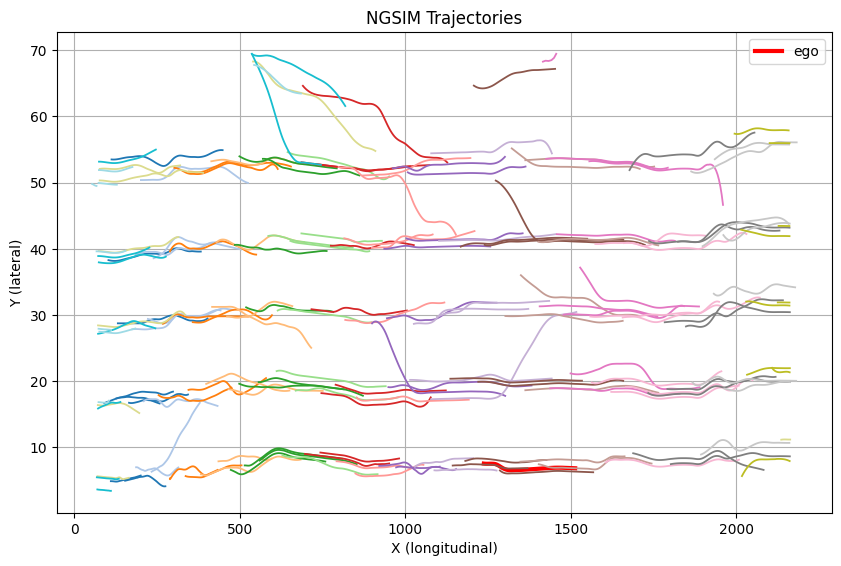

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_trajectories(trajectory_set, ego_key="ego", x_to_y_scale=20):
    plt.figure(figsize=(10, 10))

    cmap = plt.cm.get_cmap("tab20", len(trajectory_set))

    for i, (vid, meta) in enumerate(trajectory_set.items()):
        traj = meta["trajectory"]

        mask = ~((traj[:,0] == 0) & (traj[:,1] == 0))
        if mask.sum() == 0:
            continue

        traj = traj[mask]

        xs = traj[:, 1]
        ys = traj[:, 0]

        if vid == ego_key:
            plt.plot(xs, ys, linewidth=3, color="red", label="ego")
            continue

        plt.plot(xs, ys, linewidth=1.3, color=cmap(i))

    plt.xlabel("X (longitudinal)")
    plt.ylabel("Y (lateral)")
    plt.title("NGSIM Trajectories")

    # Key line: NON-EQUAL ASPECT
    plt.gca().set_aspect(x_to_y_scale)

    plt.grid(True)
    plt.legend()
    plt.show()


plot_all_trajectories(trajectory_set)


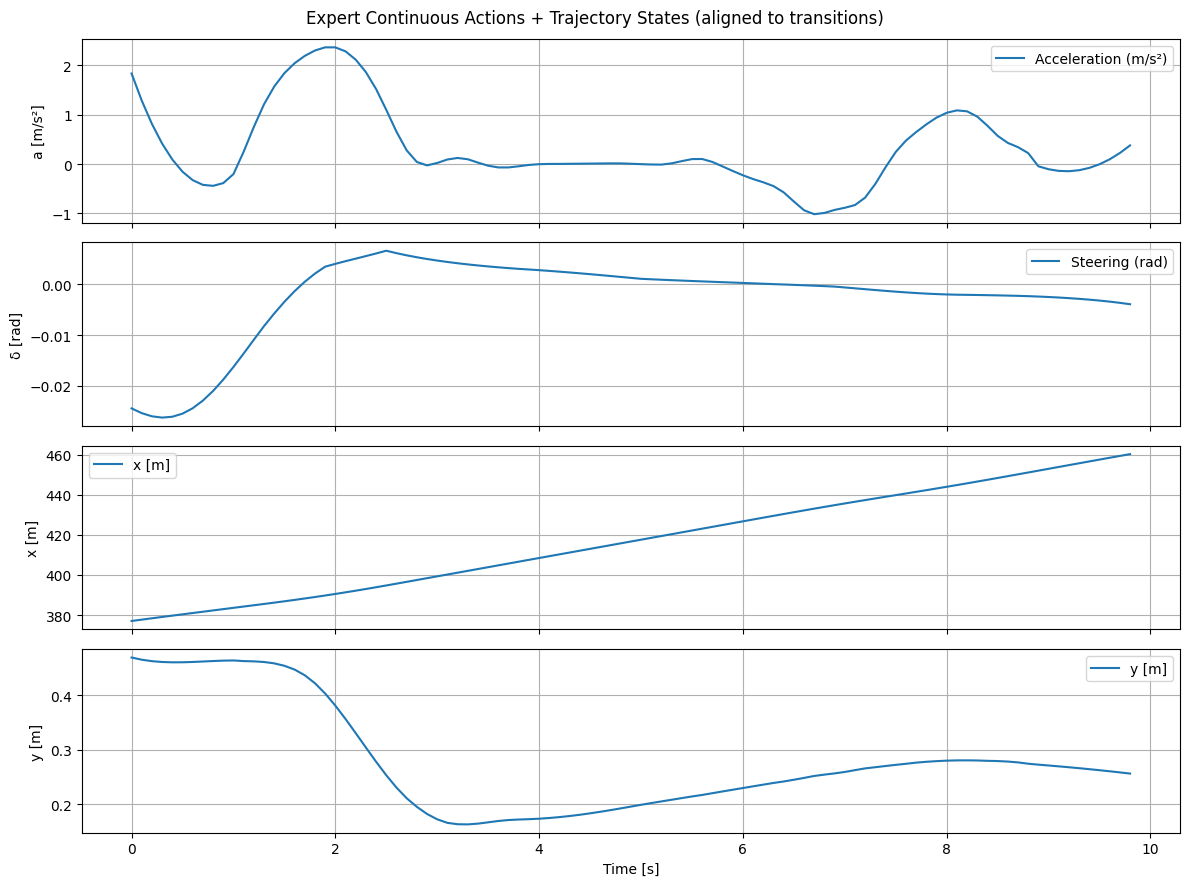

In [6]:

from highway_env.ngsim_utils.trajectory_to_action import traj_to_expert_actions

ego_traj_full_processed_raw = process_raw_trajectory(ego_traj_full)


result = traj_to_expert_actions(
    ego_traj_full_processed_raw,
    dt=0.1,
    L_forward=traj_set["ego"]["length"] / 3.281,  # NOTE: should be length/wheelbase, not width
)

start_idx = int(result["start_idx"])
end_idx   = int(result["end_idx"])   # inclusive state index for validity; actions live on [start, end)

# --- Actions are transition-defined on [start_idx, end_idx)
accel = result["accel"][start_idx:end_idx]       # length N = end-start
steer = result["steering"][start_idx:end_idx]    # length N

N = len(accel)
t = np.arange(N) * 0.1

# Valid mask for actions
valid_mask = np.isfinite(accel) & np.isfinite(steer)

# --- Align states to transitions: use states s_t for t in [start_idx, end_idx)
# This slice length is also N, matching accel/steer
xy = ego_traj_full_processed_raw[start_idx:end_idx, :2]  # shape [N,2]
x = xy[:, 0]
y = xy[:, 1]

# --- Plot ---
fig, axes = plt.subplots(4, 1, figsize=(12, 9), sharex=True)

axes[0].plot(t[valid_mask], accel[valid_mask], label="Acceleration (m/s²)")
axes[0].set_ylabel("a [m/s²]")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(t[valid_mask], steer[valid_mask], label="Steering (rad)")
axes[1].set_ylabel("δ [rad]")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(t[valid_mask], x[valid_mask], label="x [m]")
axes[2].set_ylabel("x [m]")
axes[2].grid(True)
axes[2].legend()

axes[3].plot(t[valid_mask], y[valid_mask], label="y [m]")
axes[3].set_xlabel("Time [s]")
axes[3].set_ylabel("y [m]")
axes[3].grid(True)
axes[3].legend()

plt.suptitle("Expert Continuous Actions + Trajectory States (aligned to transitions)")
plt.tight_layout()
plt.show()

In [7]:
x_last, y_last = ego_traj_full_processed_raw[-2, 0], ego_traj_full_processed_raw[-2, 1]
print("last position (x, y):", x_last, y_last)

last position (x, y): 460.2826688438173 0.25654968206947226


In [8]:
ego_traj_full_processed_raw

array([[3.77054373e+02, 4.69488990e-01, 6.19554734e+00, 1.00000000e+00],
       [3.77730725e+02, 4.65483758e-01, 6.37916704e+00, 1.00000000e+00],
       [3.78399789e+02, 4.62827756e-01, 6.50786727e+00, 1.00000000e+00],
       [3.79062607e+02, 4.61303976e-01, 6.58920977e+00, 1.00000000e+00],
       [3.79720218e+02, 4.60695414e-01, 6.63075632e+00, 1.00000000e+00],
       [3.80373663e+02, 4.60785065e-01, 6.64006865e+00, 1.00000000e+00],
       [3.81023983e+02, 4.61355923e-01, 6.62470852e+00, 1.00000000e+00],
       [3.81672219e+02, 4.62190984e-01, 6.59223769e+00, 1.00000000e+00],
       [3.82319412e+02, 4.63073242e-01, 6.55021791e+00, 1.00000000e+00],
       [3.82966602e+02, 4.63785691e-01, 6.50621093e+00, 1.00000000e+00],
       [3.83614829e+02, 4.64111327e-01, 6.46777851e+00, 1.00000000e+00],
       [3.84258242e+02, 4.62954658e-01, 6.44755947e+00, 1.00000000e+00],
       [3.84900674e+02, 4.62460964e-01, 6.47267759e+00, 1.00000000e+00],
       [3.85548085e+02, 4.61310672e-01, 6.54806683e